In [1]:
%load_ext nb_black
from IPython.core.debugger import set_trace

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

plt.style.use(style="seaborn")
%matplotlib inline

<IPython.core.display.Javascript object>

#### Read CSV

Dataset: https://www.kaggle.com/ntnu-testimon/paysim1/data

Randomly sampled 10% of the dataset and removed the labels.

In [2]:
df = pd.read_csv(
    f"data/Synthetic Financial Data.csv", encoding="ISO-8859-1", error_bad_lines=False
)

<IPython.core.display.Javascript object>

In [3]:
df.columns

Index(['Unnamed: 0', 'step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg',
       'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest',
       'isFraud', 'isFlaggedFraud'],
      dtype='object')

<IPython.core.display.Javascript object>

#### Isolation Forest

Isolation Forest is one of the most efficient algorithms for outlier detection especially in high dimensional datasets.

The model builds a Random Forest in which each Decision Tree is grown randomly. 

At each node it picks a feature randomly and then a random threshold value (between min and max) to split the dataset in two. 

As the dataset gets gradually chopped into pieces, each observation gets isolated from the others. 

Anomalies are far from the others therefore they get to be isolated in less steps than normal observations.

![](https://miro.medium.com/max/3268/1*TqkqI2QECywBLnY6KlVvHA.png)

In [4]:
df.head(2)

Unnamed: 0  step     type    amount    nameOrig  oldbalanceOrg  \
0     6322570   688  CASH_IN  23557.12  C867750533         8059.0   
1     3621196   274  PAYMENT   6236.13  C601099070            0.0   

   newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0        31616.12  C1026934669       169508.66       145951.53        0   
1            0.00   M701283411            0.00            0.00        0   

   isFlaggedFraud  
0               0  
1               0

<IPython.core.display.Javascript object>

In [5]:
df.type.value_counts()

CASH_OUT    223880
PAYMENT     214719
CASH_IN     140287
TRANSFER     53211
DEBIT         4165
Name: type, dtype: int64

<IPython.core.display.Javascript object>

In [6]:
df.amount.value_counts()

10000000.00    308
10000.00         9
15000.00         8
5000.00          8
100000.00        8
              ... 
12803.83         1
117960.49        1
179472.62        1
81215.48         1
2048.00          1
Name: amount, Length: 622269, dtype: int64

<IPython.core.display.Javascript object>

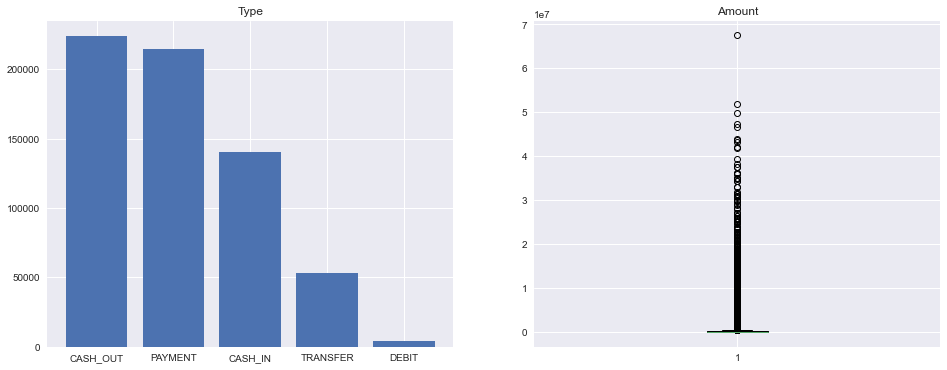

<IPython.core.display.Javascript object>

In [7]:
x = df["type"].value_counts().index
y = df["type"].value_counts().values

f = plt.figure(1, figsize=(16, 6))
ax1 = f.add_subplot(1, 2, 1)
ax1.title.set_text("Type")
_ = ax1.bar(x, y)

z = df["amount"].value_counts().index

ax2 = f.add_subplot(1, 2, 2)
ax2.title.set_text("Amount")
_ = ax2.boxplot(z)

In [8]:
from sklearn.ensemble import IsolationForest

# Estimation of anomaly population of the dataset (necessary for IForest)
contamination = 0.01

data = df.copy()

<IPython.core.display.Javascript object>

Label encode

In [9]:
for col in data.columns:
    if data[col].dtype == "object":
        le = LabelEncoder()
        data[col].fillna("None", inplace=True)
        le.fit(list(data[col].astype(str).values))
        data[col] = le.transform(list(data[col].astype(str).values))
    else:
        data[col].fillna(-999, inplace=True)

<IPython.core.display.Javascript object>

In [10]:
data.head(2)

Unnamed: 0  step  type    amount  nameOrig  oldbalanceOrg  newbalanceOrig  \
0     6322570   688     0  23557.12    592758         8059.0        31616.12   
1     3621196   274     3   6236.13    505091            0.0            0.00   

   nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0      3396       169508.66       145951.53        0               0  
1    423740            0.00            0.00        0               0

<IPython.core.display.Javascript object>

In [11]:
%%time
model = IsolationForest(contamination=contamination, n_estimators=1000)
model.fit(data)

CPU times: user 2min 31s, sys: 17.4 s, total: 2min 49s
Wall time: 2min 49s


IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.01,
                max_features=1.0, max_samples='auto', n_estimators=1000,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

<IPython.core.display.Javascript object>

In [12]:
df["iforest"] = pd.Series(model.predict(data))
df["iforest"] = df["iforest"].map({1: 0, -1: 1})
print(df["iforest"].value_counts())

0    629899
1      6363
Name: iforest, dtype: int64


<IPython.core.display.Javascript object>

In [13]:
6363 / 629899

0.010101619465977879

<IPython.core.display.Javascript object>

In [14]:
df.drop(columns=["Unnamed: 0", "isFraud", "isFlaggedFraud"], inplace=True)

<IPython.core.display.Javascript object>

In [18]:
df.head(25)

step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0    688   CASH_IN   23557.12   C867750533        8059.00        31616.12   
1    274   PAYMENT    6236.13   C601099070           0.00            0.00   
2    133   PAYMENT   33981.87   C279540931       18745.72            0.00   
3    225  CASH_OUT  263006.42    C11675531       20072.00            0.00   
4    249  CASH_OUT  152013.74   C530649214       20765.00            0.00   
5    276   PAYMENT    2854.62  C1176841830           0.00            0.00   
6    137  CASH_OUT  336874.19  C1430396546      201316.00            0.00   
7    378  CASH_OUT  520230.74  C1815050914           0.00            0.00   
8    403   CASH_IN   51179.09  C1451233962     8278679.08      8329858.17   
9    202  TRANSFER  735977.55  C1864759705        8900.00            0.00   
10   380  CASH_OUT  112606.21  C1279551023           0.00            0.00   
11   346  CASH_OUT   99203.70   C339611757       22297.00            0.00   
12   209   CASH_IN  321631.56   C214232645     6611197.56      6932829.13   
13   231   CASH_IN  408320.59   C147558429         995.00       409315.59   
14   300   PAYMENT   22950.32   C589306939      153400.54       130450.21   
15    15  TRANSFER  151878.25  C1340160492      269539.00       117660.75   
16    15   PAYMENT   10315.59  C1691041888       51275.00        40959.41   
17   229   PAYMENT   29748.71   C646772953         171.00            0.00   
18   133  CASH_OUT  180171.05   C358340052       56503.00            0.00   
19   256   PAYMENT    9746.91  C2111839967       91401.09        81654.17   
20   161   PAYMENT    7810.53  C1177292228        2146.00            0.00   
21   259   PAYMENT    3816.49  C1531099717      115421.00       111604.51   
22   130   PAYMENT    3144.66  C2143875111       21028.00        17883.34   
23   332   PAYMENT   14025.33  C1016295874      205423.00       191397.67   
24   256  CASH_OUT   52611.00   C463257434       12433.00            0.00   

       nameDest  oldbalanceDest  newbalanceDest  iforest  
0   C1026934669       169508.66       145951.53        0  
1    M701283411            0.00            0.00        0  
2    M577905776            0.00            0.00        0  
3    C529577791       390253.56       653259.98        0  
4   C1304175579       252719.19       404732.93        0  
5   M1392929452            0.00            0.00        0  
6   C1687236810        20820.92       357695.11        0  
7   C1640500532       540059.79      1060290.53        0  
8    C330970462       602965.54       551786.46        0  
9   C2022704650            0.00       735977.55        0  
10   C356338918       151260.04       263866.25        0  
11  C1223540220            0.00        99203.70        0  
12   C412261249      1103286.62       781655.06        0  
13   C921825569      1397750.17       989429.58        0  
14   M455756256            0.00            0.00        0  
15  C1379646923       349458.57       501336.82        0  
16   M760405926            0.00            0.00        0  
17  M1463899796            0.00            0.00        0  
18   C763707545       257898.04       438069.10        0  
19  M1628040249            0.00            0.00        0  
20   M709861523            0.00            0.00        0  
21  M1938922718            0.00            0.00        0  
22   M214475916            0.00            0.00        0  
23   M304573061            0.00            0.00        0  
24   C235021433      1941074.35      1993685.35        0

<IPython.core.display.Javascript object>

In [19]:
exp = []
for col in df.columns[:-1]:
    norm = pd.Series.to_dict(df[df.iforest == 0][col].value_counts())
    anom = pd.Series.to_dict(df[df.iforest == 1][col].value_counts())

    keys = set(anom.keys())

    if keys:
        exp.append(col)

<IPython.core.display.Javascript object>

In [20]:
exp

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest']

<IPython.core.display.Javascript object>

In [21]:
norm = pd.Series.to_dict(df[df.iforest == 0].type.value_counts())
anom = pd.Series.to_dict(df[df.iforest == 1].type.value_counts())

<IPython.core.display.Javascript object>

In [22]:
anom

{'CASH_IN': 4204, 'TRANSFER': 1925, 'CASH_OUT': 222, 'PAYMENT': 7, 'DEBIT': 5}

<IPython.core.display.Javascript object>

In [23]:
norm

{'CASH_OUT': 223658,
 'PAYMENT': 214712,
 'CASH_IN': 136083,
 'TRANSFER': 51286,
 'DEBIT': 4160}

<IPython.core.display.Javascript object>

In [24]:
keys = set(anom.keys())
keys

{'CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER'}

<IPython.core.display.Javascript object>

In [25]:
n = {}
o = {}
for k in keys:
    try:
        n[k] = 100 * norm[k] / sum(list(norm.values()))
    except:
        n[k] = 0
    o[k] = 100 * anom[k] / sum(list(anom.values()))

<IPython.core.display.Javascript object>

In [26]:
o = {k: v for k, v in sorted(o.items(), key=lambda item: item[1], reverse=True)}

<IPython.core.display.Javascript object>

In [27]:
o

{'CASH_IN': 66.06946408926606,
 'TRANSFER': 30.253025302530254,
 'CASH_OUT': 3.488920320603489,
 'PAYMENT': 0.11001100110011001,
 'DEBIT': 0.07857928650007857}

<IPython.core.display.Javascript object>

In [31]:
sum(list(o.values()))

99.99999999999999

<IPython.core.display.Javascript object>

In [32]:
n

{'PAYMENT': 34.086734539981805,
 'CASH_IN': 21.603939679218414,
 'DEBIT': 0.6604233377096963,
 'CASH_OUT': 35.506962227277704,
 'TRANSFER': 8.141940215812376}

<IPython.core.display.Javascript object>

In [33]:
from itertools import islice

o = dict(islice(o.items(), 1))

<IPython.core.display.Javascript object>

In [34]:
o

{'CASH_IN': 66.06946408926606}

<IPython.core.display.Javascript object>

In [35]:
list(o.values())[0]

66.06946408926606

<IPython.core.display.Javascript object>

In [36]:
n[list(o.keys())[0]]

21.603939679218414

<IPython.core.display.Javascript object>

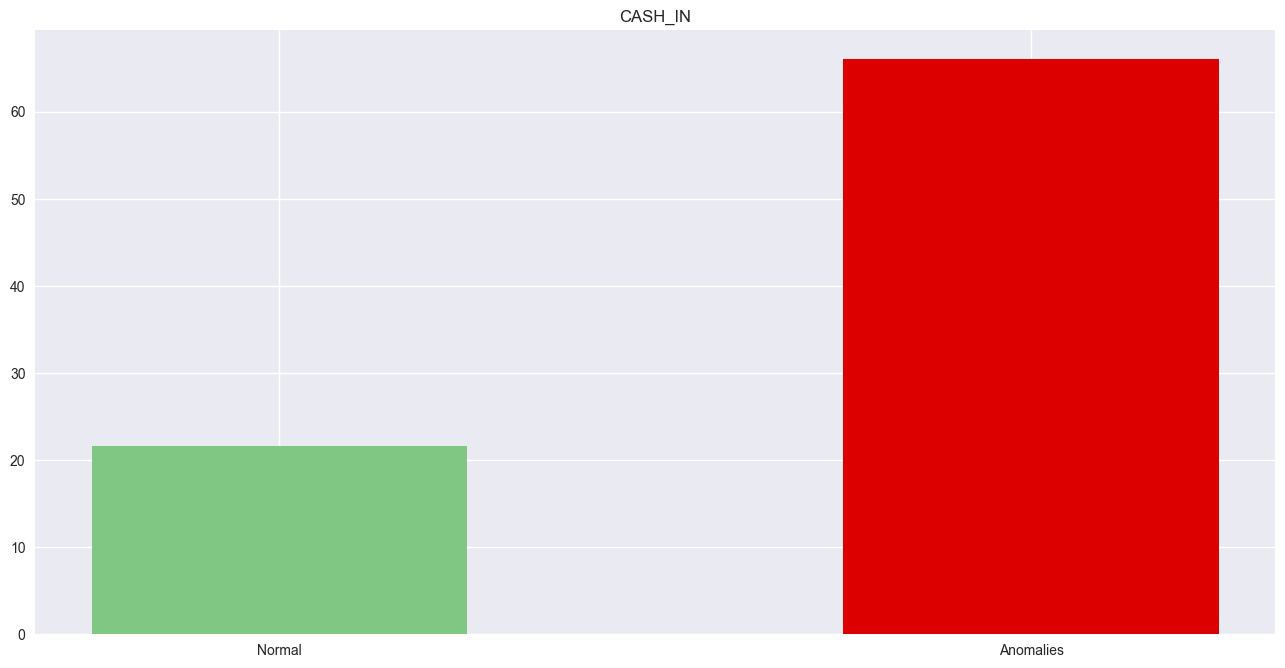

<IPython.core.display.Javascript object>

In [37]:
f = plt.figure(1, figsize=(16, 8), dpi=100)
ax = f.add_subplot(1, 1, 1)
ax.title.set_text("CASH_IN")
_ = ax.bar("Normal", n[list(o.keys())[0]], align="center", width=0.5, color="#81C784")
_ = ax.bar("Anomalies", list(o.values())[0], align="center", width=0.5, color="#DD0000")

In [38]:
for col in exp:
    norm = pd.Series.to_dict(df[df.iforest == 0][col].value_counts())
    anom = pd.Series.to_dict(df[df.iforest == 1][col].value_counts())

    keys = set(anom.keys())

    n = {}
    o = {}
    for k in keys:
        try:
            n[k] = 100 * norm[k] / sum(list(norm.values()))
        except:
            n[k] = 0
        o[k] = 100 * anom[k] / sum(list(anom.values()))

    n = {k: v for k, v in sorted(n.items(), key=lambda item: item[1], reverse=True)}
    o = {k: v for k, v in sorted(o.items(), key=lambda item: item[1], reverse=True)}

    from itertools import islice

    n = dict(islice(n.items(), 5))
    o = dict(islice(o.items(), 5))

    print(f"Column {col}:")
    for i in o.keys():
        try:
            print(f"{i}: Normal: {n[i]}% vs Anomalies: {o[i]}%")
        except:
            pass

Column step:
19: Normal: 0.7840939579202381% vs Anomalies: 1.335847870501336%
Column type:
CASH_IN: Normal: 21.603939679218414% vs Anomalies: 66.06946408926606%
TRANSFER: Normal: 8.141940215812376% vs Anomalies: 30.253025302530254%
CASH_OUT: Normal: 35.506962227277704% vs Anomalies: 3.488920320603489%
PAYMENT: Normal: 34.086734539981805% vs Anomalies: 0.11001100110011001%
DEBIT: Normal: 0.6604233377096963% vs Anomalies: 0.07857928650007857%
Column amount:
10000000.0: Normal: 0.011906670751977698% vs Anomalies: 3.661794750903662%
100000.0: Normal: 0.0004762668300791079% vs Anomalies: 0.07857928650007857%
10000.0: Normal: 0.0006350224401054772% vs Anomalies: 0.07857928650007857%
5000.0: Normal: 0.0006350224401054772% vs Anomalies: 0.06286342920006287%
Column nameOrig:
C299899481: Normal: 0% vs Anomalies: 0.015715857300015717%
C827599902: Normal: 0% vs Anomalies: 0.015715857300015717%
C1781553211: Normal: 0% vs Anomalies: 0.015715857300015717%
C1114432428: Normal: 0% vs Anomalies: 0.01571

<IPython.core.display.Javascript object>